# Explore here

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.metrics import *
from imblearn.metrics import specificity_score

url = "/workspaces/Boosting_PereHDZ/diabetes_data.csv"

df = pd.read_csv(url, sep=',')

df.to_csv('diabetes-data.csv', index=False)

columns_with_impossible_0 = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columns_with_impossible_0:
    median_value = df[col][df[col] != 0].median()
    df[col] = df[col].replace(0, median_value)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,125,33.6,0.627,50,1
1,1,85,66,29,125,26.6,0.351,31,0
2,8,183,64,29,125,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [14]:
#Now that the 0s are dealt with, we can proceed with the data split
df_scaled = pd.DataFrame(data=StandardScaler().fit_transform(df.drop(['Outcome'], axis = 1)), columns=df.columns[: -1])
df_scaled['Outcome'] = df.Outcome

X = df_scaled.drop(['Outcome'], axis=1)
y = df_scaled['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create the boosting class
class GradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        residuals = y.copy()
        
        for _ in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            pred = tree.predict(X)

            residuals -= self.learning_rate * pred

            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])

        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        
        return predictions
    
gb_model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)

train_pred = gb_model.predict(X_train)
test_pred = gb_model.predict(X_test)

#Create function to get the metrics
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

train_pred_class = (train_pred >= 0.5).astype(int)
test_pred_class = (test_pred >= 0.5).astype(int)

get_metrics(y_train, y_test, train_pred_class, test_pred_class)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.907166,0.857143,0.882705,0.919355,0.802817,0.962594
Test,0.759740,0.666667,0.740404,0.660714,0.672727,0.808081
Diferencia,0.147426,0.190476,0.142301,0.258641,0.130090,0.154513


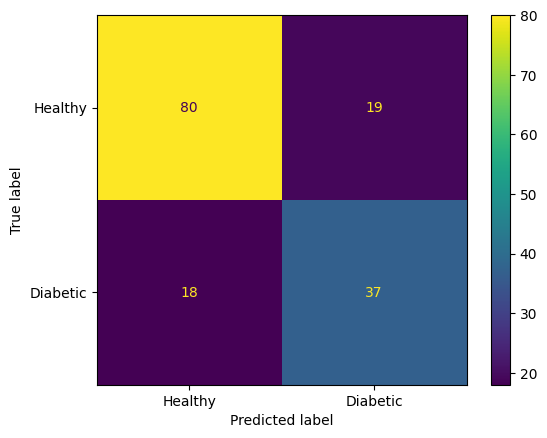

In [15]:
#Plot confusion matrix
cm = confusion_matrix(y_test, test_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Diabetic'])
disp.plot()

After doing 3 different models (decission tree, random forest and boosting), if we go by accuracy alone (like the exercise suggests), the superior model is the random forest one, which gets a 78'5% accuracy in both its training and testing sets. This is probably due to the fact that our dataset is small, and random tree algorithms work best in smaller datasets.

Analyzing the boosting model we just created, we can see that it has a specificity of 80% but a recall of only 67%. This is probably due to the fact that our dataset has more healthy people than diabetic ones, which tends to skew the predictions towards healthy.

None of our three models reaches a 90% accuracy in any of our testing. The results are too low for a medical setting and thus not applicable in real life. Some possible fixes to this problem would be to use a bigger sample or a different model altogether.